In [1]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import random
random.seed(1447)

In [2]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [3]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

## Import Data

#### Manufacturing variable costs

In [4]:
# Import Costs
manvar_costs = pd.read_excel('data/variable costs.xlsx', index_col = 0)
manvar_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


#### Freight costs

In [5]:
# Import Costs
freight_costs = pd.read_excel('data/freight costs.xlsx', index_col = 0)
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


#### Variable Costs

In [6]:
# Factory + Freight Variable Costs
var_cost = freight_costs/1000 + manvar_costs 
var_cost

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


#### Fixed Costs

In [7]:
# Factory Fixed Costs
fixed_costs = pd.read_excel('data/fixed cost.xlsx', index_col = 0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


#### Plants Capacity

In [8]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel('data/capacity.xlsx', index_col = 0)
cap

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


#### Demand 

In [9]:
# Demand by Market
demand = pd.read_excel('data/demand.xlsx', index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


---

## Initial Calculation 
(1 Scenario)

In [10]:
# Define Decision Variables
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
prod_name = [(i,j) for i in loc for j in loc]   

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])                                                 
                                                       
# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['Plant Opening'])
df_bool

Status: Optimal
Total Costs: 65,118,000 ($/Month)


c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


#### Plant Opening

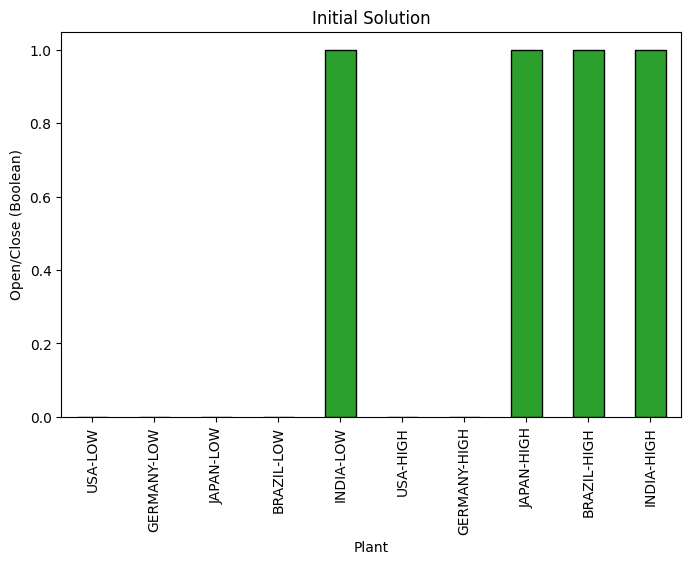

In [11]:
# Plant Opening
cap_plot = cap.copy()

ax = df_bool.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

---

### Functions to simulate several scenarios
#### Funtion to build the model

In [12]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]   

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_", 
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])                                                 
    # Solve Model
    model.solve()
    
    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

#### Build the normal distribution of demand: N(demand, demand x COV)

In [13]:
# Normal Distribution
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
# Demand 
CV = 0.5
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('data/df_demand-{}PC.xlsx'.format(int(CV * 100)))
    
df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,4060787,88479,1554984,100922,102540
1,2,1915647,106168,2313678,215939,169115
2,3,923729,95022,2226707,122756,63001
3,4,2670167,113220,1539380,95690,178081


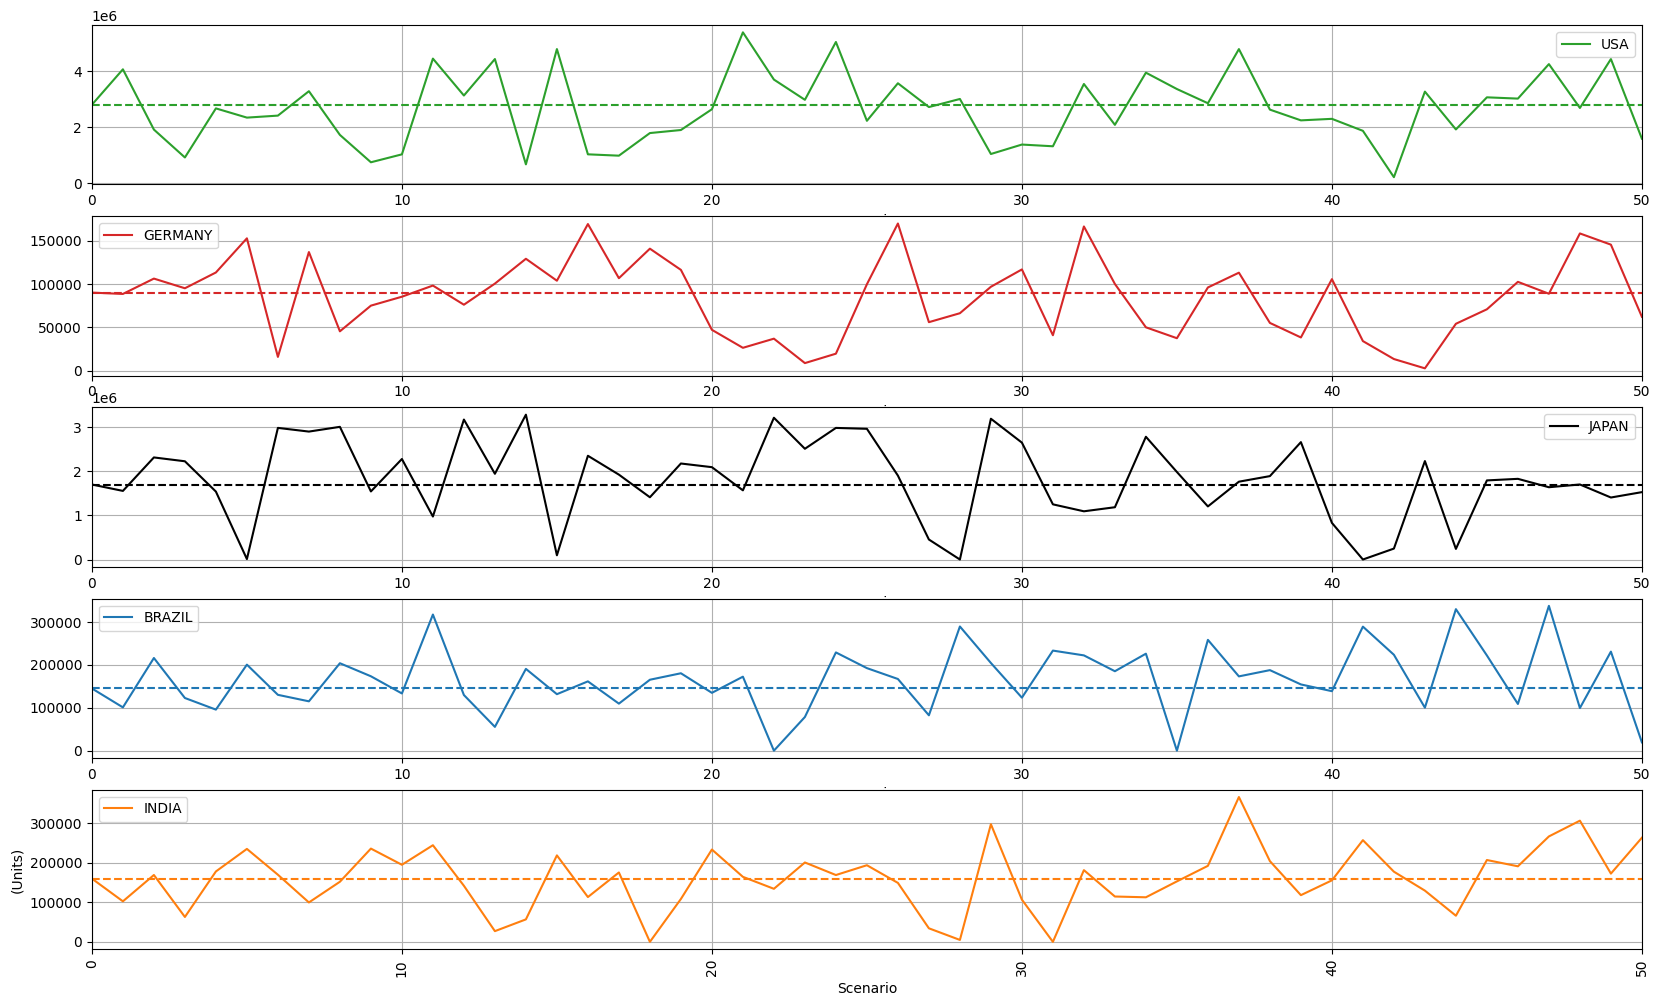

In [14]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

#### Calculation: Initial Scenario

In [15]:
# Record results per scenario
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['INITIAL'])
df_bool.head()

c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,INITIAL
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0


In [16]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario 
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)    
    
    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel('data/boolean-{}PC.xlsx'.format(int(CV * 100)))
# Other Results
df_bool.head()

c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\Users\Anshif\AppData\Local\Programs\Python\Python312\Lib\

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
JAPAN-LOW,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
BRAZIL-LOW,0,0,0,0,0,1,1,1,0,1,0,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,1,0,0,0
INDIA-LOW,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1


In [17]:
# Unique configurations
df_candidates = df_bool.T.drop_duplicates().T
df_candidates


,INITIAL,2,4,5,6,7,9,10,13,20,21,23,34,40,41,46
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
JAPAN-LOW,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
BRAZIL-LOW,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1
INDIA-LOW,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1
USA-HIGH,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
GERMANY-HIGH,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
JAPAN-HIGH,1,0,0,1,1,1,0,1,1,1,1,1,1,0,0,1
BRAZIL-HIGH,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1
INDIA-HIGH,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1


In [18]:
def second_stage_model(fixed_costs, var_cost, demand, demand_col, cap, y_fixed):
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]

    model = LpProblem("Evaluation_Model", LpMinimize)

    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')

    # Objective: fixed y cost is constant now
    model += (
        lpSum([fixed_costs.loc[i,s] * y_fixed[k] * 1000 
               for k,(i,s) in enumerate(plant_name)])
        +
        lpSum([var_cost.loc[i,j] * x[(i,j)] for i in loc for j in loc])
    )

    # Demand constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]

    # Capacity constraints using fixed y
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum(
            [cap.loc[i,s] * y_fixed[k] * 1000 
             for k,(ii,s) in enumerate(plant_name) if ii==i]
        )

    model.solve()

    return pulp.value(model.objective)


In [19]:
results = []

for c in df_candidates.columns:          # each candidate configuration
    y_fixed = df_candidates[c].values
    
    for s in demand_var.columns:         # each demand scenario
        cost = second_stage_model(
            fixed_costs, var_cost, demand_var, s, cap, y_fixed
        )
        
        results.append([c, s, cost])

df_eval = pd.DataFrame(results, columns=['Candidate','Scenario','Cost'])
df_eval.head()


,Candidate,Scenario,Cost
0,INITIAL,0,1.389146e+08
1,INITIAL,0,1.389146e+08
2,INITIAL,1,6.408319e+07
3,INITIAL,2,5.139084e+07
4,INITIAL,3,6.186641e+07


In [20]:
df_stats = df_eval.groupby('Candidate')['Cost'].agg(
    Mean='mean',
    Std='std',
    Worst='max',
    Best='min'
).reset_index()

df_stats


,Candidate,Mean,Std,Worst,Best
0,2,6.218176e+07,2.247536e+07,1.313648e+08,1.942062e+07
1,4,6.243712e+07,2.307878e+07,1.321203e+08,1.731062e+07
2,5,7.751700e+07,2.069432e+07,1.447446e+08,3.798062e+07
3,6,8.003901e+07,2.218345e+07,1.498152e+08,3.902062e+07
4,7,7.173113e+07,2.098867e+07,1.398671e+08,3.175062e+07
5,9,6.504221e+07,2.199511e+07,1.334293e+08,2.265062e+07
6,10,7.840447e+07,2.093729e+07,1.434342e+08,3.802062e+07
7,13,6.852871e+07,2.221363e+07,1.407821e+08,2.641062e+07
8,20,8.647515e+07,2.086298e+07,1.502537e+08,4.623062e+07
9,21,8.540550e+07,2.138561e+07,1.520146e+08,4.525062e+07


In [21]:
alpha = 0.9

def compute_var_cvar(costs, alpha=0.9):
    costs_sorted = np.sort(costs)
    S = len(costs_sorted)
    
    # VaR index
    var_index = int(np.ceil(alpha * S)) - 1
    var_alpha = costs_sorted[var_index]
    
    # CVaR = mean of tail
    cvar_alpha = costs_sorted[var_index:].mean()
    
    return var_alpha, cvar_alpha


# Compute stats per candidate
records = []

for cand in df_eval['Candidate'].unique():
    costs = df_eval[df_eval['Candidate'] == cand]['Cost'].values
    
    var_09, cvar_09 = compute_var_cvar(costs, alpha)
    
    records.append({
        'Candidate': cand,
        'Mean': costs.mean(),
        'Std': costs.std(),
        'VaR_0.9': var_09,
        'CVaR_0.9': cvar_09,
        'Worst': costs.max()
    })

df_risk = pd.DataFrame(records)
df_risk


,Candidate,Mean,Std,VaR_0.9,CVaR_0.9,Worst
0,INITIAL,6.874309e+07,2.131784e+07,9.036863e+07,1.106721e+08,1.389146e+08
1,2,6.218176e+07,2.225392e+07,8.761513e+07,1.056412e+08,1.313648e+08
2,4,6.243712e+07,2.285140e+07,8.837063e+07,1.068791e+08,1.321203e+08
3,5,7.751700e+07,2.049043e+07,9.912364e+07,1.170330e+08,1.447446e+08
4,6,8.003901e+07,2.196489e+07,1.047461e+08,1.228360e+08,1.498152e+08
5,7,7.173113e+07,2.078188e+07,9.184460e+07,1.119695e+08,1.398671e+08
6,9,6.504221e+07,2.177840e+07,8.967963e+07,1.077057e+08,1.334293e+08
7,10,7.840447e+07,2.073100e+07,1.002645e+08,1.171995e+08,1.434342e+08
8,13,6.852871e+07,2.199477e+07,9.112413e+07,1.119836e+08,1.407821e+08
9,20,8.647515e+07,2.065743e+07,1.095374e+08,1.260404e+08,1.502537e+08


In [22]:
best_row = df_risk.loc[df_risk['CVaR_0.9'].idxmin()]

best_candidate = best_row['Candidate']
best_cvar = best_row['CVaR_0.9']

best_candidate, best_cvar


(2, np.float64(105641242.74599999))

In [23]:
best_design = df_candidates[best_candidate]

best_design


USA-LOW         0
GERMANY-LOW     0
JAPAN-LOW       0
BRAZIL-LOW      0
INDIA-LOW       1
USA-HIGH        0
GERMANY-HIGH    0
JAPAN-HIGH      0
BRAZIL-HIGH     1
INDIA-HIGH      1
Name: 2, dtype: int64

In [24]:
df_risk_sorted = df_risk.sort_values('CVaR_0.9').reset_index(drop=True)
df_risk_sorted


,Candidate,Mean,Std,VaR_0.9,CVaR_0.9,Worst
0,2,6.218176e+07,2.225392e+07,8.761513e+07,1.056412e+08,1.313648e+08
1,4,6.243712e+07,2.285140e+07,8.837063e+07,1.068791e+08,1.321203e+08
2,9,6.504221e+07,2.177840e+07,8.967963e+07,1.077057e+08,1.334293e+08
3,40,6.230234e+07,2.349394e+07,8.844613e+07,1.077941e+08,1.341582e+08
4,INITIAL,6.874309e+07,2.131784e+07,9.036863e+07,1.106721e+08,1.389146e+08
5,7,7.173113e+07,2.078188e+07,9.184460e+07,1.119695e+08,1.398671e+08
6,13,6.852871e+07,2.199477e+07,9.112413e+07,1.119836e+08,1.407821e+08
7,41,6.421300e+07,2.531049e+07,9.088263e+07,1.120583e+08,1.426996e+08
8,5,7.751700e+07,2.049043e+07,9.912364e+07,1.170330e+08,1.447446e+08
9,10,7.840447e+07,2.073100e+07,1.002645e+08,1.171995e+08,1.434342e+08


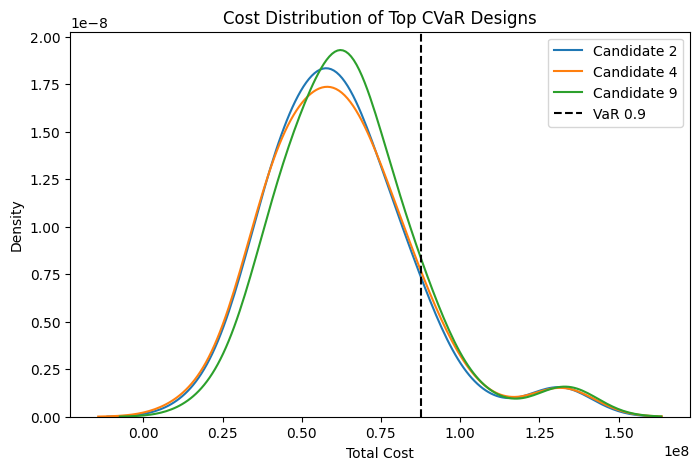

In [25]:
import seaborn as sns

top_k = df_risk_sorted['Candidate'].head(3)

plt.figure(figsize=(8,5))
for cand in top_k:
    sns.kdeplot(
        df_eval[df_eval['Candidate'] == cand]['Cost'],
        label=f'Candidate {cand}'
    )

plt.axvline(best_row['VaR_0.9'], linestyle='--', color='black', label='VaR 0.9')
plt.title('Cost Distribution of Top CVaR Designs')
plt.xlabel('Total Cost')
plt.legend()
plt.show()
